In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import matplotlib.pyplot as plt
from time import time
import sys
from abel.direct import direct_transform
from abel.tools.analytical import GaussianAnalytical
from xbeamfit import fitting
from xbeamfit import distributions 
import json
import numpy as np
import scipy as sp
import pandas as pd
import sys
import xbeamfit as xb 
from scipy import interpolate
from numpy import trapz
import scipy.integrate as integrate
from scipy import special
from scipy.stats import norm

from scipy.stats import chi
from scipy.stats import chi2

## Introduction 

Let us consider the normalized phase space $x-p_x$ and a 2D matched density distribution $\rho$.

For the linear case, a matched distribution is rotation invariant, that is, in the $J_x,\phi$ variables, we can write $\rho(r=\sqrt{2 J_x},\phi)=\rho(r)$.

Where $r = \sqrt{x^2 + x'^2}$

and $J_x = r^2/2$ the action. 



Here we use the $r$-notation instead of the $J$-notation to stay compatible with the Abel transform's standard form.
We consider for $\rho$ the following normalization:
$$
\int_0^\infty  \int_0^{2\pi} \rho( r ) \ r\ dr\ d\phi = 2\pi \int_0^\infty  \rho( r ) \ r\ dr =1.
$$

By defining a linear radial density $\rho_r(r)=2\pi \rho(r) \ r$, we have

$$
\int_0^\infty \rho_r( r ) dr= 1
$$


We would like to have a way of going between the distribution in $x$, the line density $PDF(r)$, and the distribution in terms of the action, $PDF(J_x) $ for an arbitrary, normalised beam profile in $x$. 


https://gitlab.cern.ch/sterbini/bblumi/blob/master/docs/how-tos/abel_transform/Abel_Transform.md

## Problem: 

Given a physical space distribution of a particle beam in x, can we find the percentage of the particles which are removed from the beam when a collimator is at $x$ = 4.5 $\sigma$, meaning a matched cut of $J_x$ = 4.5 $\sigma$?

$r = \sqrt{x^2 + x'^2}$

$J_x = r^2/2$ the action. 


We want to go from the normalised phase space in $x, x'$ of the Hamiltonian density, to the beam profile distribution in physical/ normal space.

We can work in reverse, going from a beam profile distribution in $x$, assuming the distribution is symmetric and normalising it. 

## 1. Normalise the distribution using the machine parameters at the measurement point 

To go from physical to normalised coordinates we apply the matrix in 2D normalisation to matrix in $x$ and $x'$



\begin{bmatrix}
    1/\sqrt\beta & 0 \\
    \alpha/\sqrt\beta & \sqrt\beta
  \end{bmatrix}
  




## 2. Given the normalised p.d.f distribution in $x$, which is symmetric about 0, transform using the Abel transform to get PDF$(r)$

For a non-Gaussian distribution in $x(\sigma)$, we want to find the PDF($J_x$). $


We can use the inverse Abel transform to go from the $x(\sigma)$ to PDF$(r)$, removing the dependence on $\phi$ because it is circularly symmetric. 



The inverse Abel transform is defined as: 
$$
f(r)=-{\frac {1}{\pi }}\int _{r}^{\infty }{\frac {dF}{dy}}\,{\frac {dy}{\sqrt {y^{2}-r^{2}}}}
$$

Where $F(x,y)$ is a circularly symmetric function, for example a beam profile which is symmetric about $x=0$. 





The inverse Abel transform projects the 1D distribution in $x$, to a distribution in $r=\sqrt{x^2 + x'^2}$ requiring that the distribution is normalised, meaning the phase space ellipse is circular. We can use this to find a line density of particles along r, by multiplying by $2\pi r$ . 


$$
PDF(r)= 2 \pi r  \mathcal{A}^{-1} [PDF(x)] 
$$

Where $\mathcal{A}^{-1}$ is the inverse Abel transform. 


## 3. Given a distribution $PDF(r)$, can we find the $PDF(J_x)$ where $J_x = r^2/2$

From probability theory:

If $F_X(x)$  is a PDF of a random variable $X$, 


and $Y= g(X)$, and 
- $g(x)$ is differentiable
- $g(x)$ is a strictly increasing function: $x_1 < x_2 $ then $g(x_1) < g(x_2)$

Then:

$$
F_Y(y) = F_X(x_1)/g'(x_1) 
$$

Where $g(x_1) = y$

https://www.probabilitycourse.com/chapter4/4_1_3_functions_continuous_var.php


Translating our problem from going from $r$ to Action $J_x$:


Then we can find the PDF of $J_x = r^2/2$ from the PDF of $r$, 


$$
g(r) = r^2/2, g'(r) = r 
$$


$$
PDF(J_x) = PDF(r)/r
$$

### Example: For a Gaussian beam distribution 

Falling back to a pure Python backend...


Text(0, 0.5, 'p.d.f')

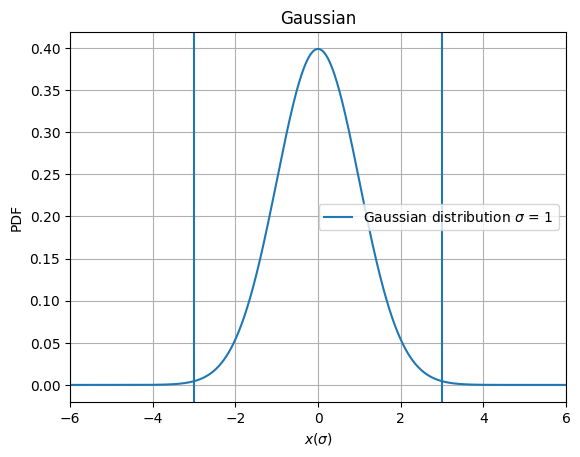

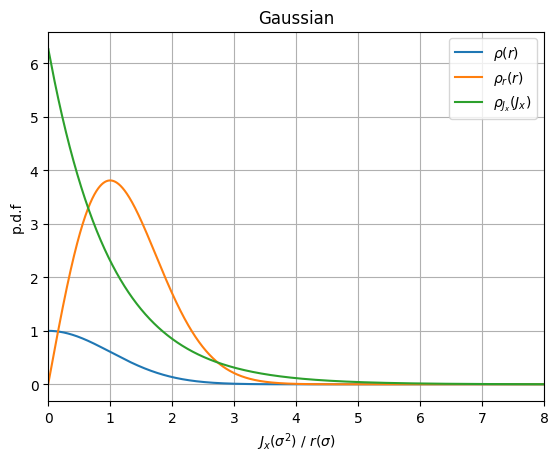

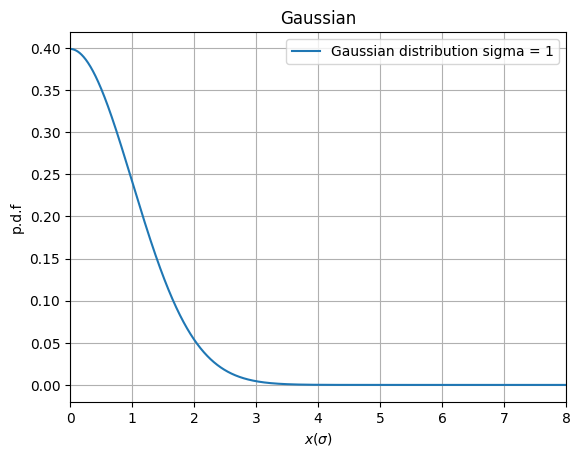

In [2]:
############ normalised beam distribution symmetric about 0 
x = np.linspace(-20,20,20000)


gauss = xb.distributions.Gaussian(x,mu=0,sig=1,A=1)

plt.figure()
plt.plot(x,gauss, label='Gaussian distribution $\sigma$ = 1')
plt.legend()
plt.xlim([-6,6])
plt.grid()
plt.title('Gaussian')
plt.xlabel('$x(\sigma)$')
plt.ylabel('PDF')
plt.axvline(x=3)
plt.axvline(x=-3)
plt.savefig('./presentation_plots/collimator_x_gaussian.png', dpi=400)

############ Inverse Abel transform of only the POSITIVE DEFINED part of the distribution 

r = np.linspace(0.00001,20,10000)

abel_gauss = direct_transform(gauss[10000:].copy(), dr=np.diff(x)[0], direction="Inverse", correction=True)




rho_r_r_gauss = r*abel_gauss*2*np.pi



########### Find the pdf in Jx 

pdf_jx_gauss = rho_r_r_gauss/r
jx = r**2/2


plt.figure()
plt.plot(r, abel_gauss,label='$\\rho(r)$')
plt.legend()
plt.plot(r,rho_r_r_gauss, label='$\\rho_r(r)$')
plt.plot(jx,pdf_jx_gauss, label='$\\rho_{J_x}(J_x)$')
plt.legend()
plt.xlim([0,8])
plt.grid()
plt.title('Gaussian')
plt.xlabel('$J_x(\sigma^2$) / $r(\sigma)$')
plt.ylabel('p.d.f')


plt.figure()
plt.plot(x,gauss, label='Gaussian distribution sigma = 1')
plt.legend()
plt.xlim([0,8])
plt.grid()
plt.title('Gaussian')
plt.xlabel('$x(\sigma)$')
plt.ylabel('p.d.f')



4.5 sigma cut takes  1.1103200116124157 %


Text(0, 0.5, 'p.d.f')

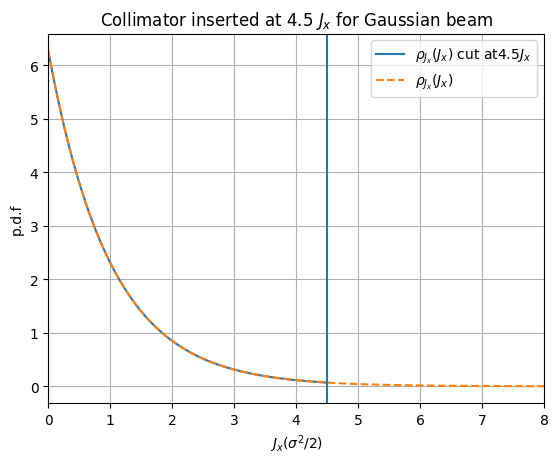

In [59]:
########## define a collimator position in J_x (x^2/2)

collim_position = 3**2/2


######### interpolate the pdf of J_x to find the curve up to the desired collimator position 

xcollim_g = np.linspace(0.0000,collim_position,200) # 0 to 3 sigma
x = jx
y = pdf_jx_gauss
ycollim_g = np.interp(xcollim_g, x, y)


########### integrate the interpolated function and the pdf of J_x 

perc_cut = sp.integrate.simps(ycollim_g, x=xcollim_g, dx=1, axis=-1,)
perc_all = sp.integrate.simps(pdf_jx_gauss, x=jx, dx=1, axis=-1,)

########### calculate percentage lost 

perc_g = 100-(perc_cut/perc_all*100)
print(str(collim_position) , 'sigma cut takes ',  perc_g, '%')


########### plot 

plt.figure()
plt.plot(xcollim_g, ycollim_g, label='$\\rho_{J_x}(J_x)$ cut at' + str(collim_position) + '$J_x$ ')
plt.plot(jx,pdf_jx_gauss, linestyle= '--',label='$\\rho_{J_x}(J_x)$',)
plt.legend()
plt.grid()
plt.title('Collimator inserted at ' + str(collim_position) + ' $J_x$ for Gaussian beam')
plt.xlabel('$J_x(\\sigma^2/2)$')
plt.axvline(x=collim_position)
plt.xlim([0,8])
plt.ylabel('p.d.f')




### Refind the distribution after the collimator has removed some beam

Falling back to a pure Python backend...


(0.0, 4.0)

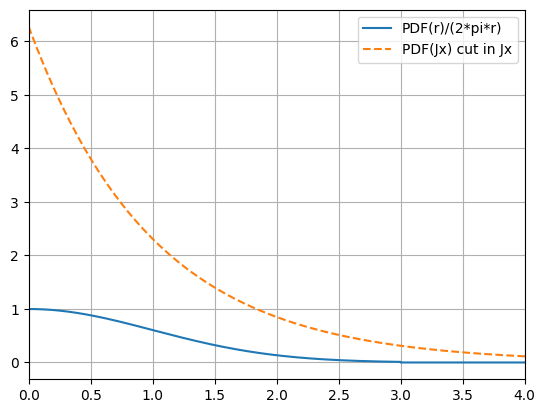

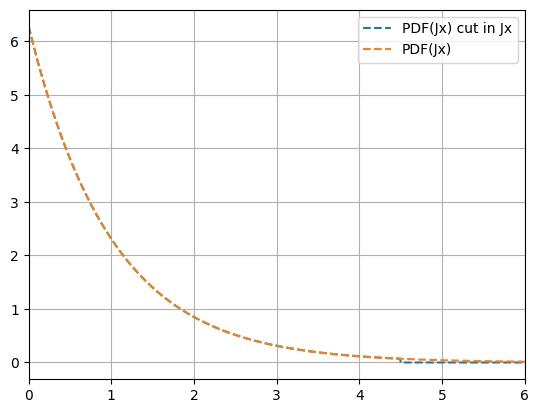

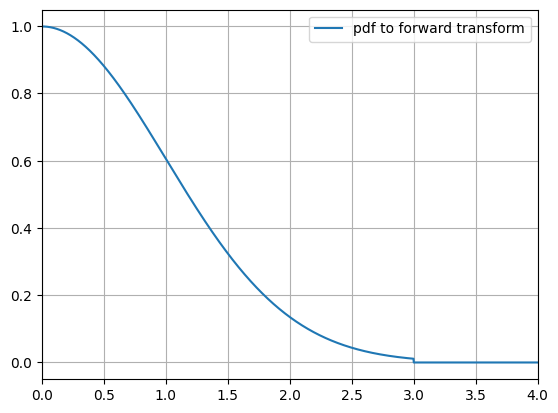

In [58]:


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


# find the index of Jx closest to
nearest, idx = find_nearest(jx, collim_position)

# make the array 0 after 4.5 sigma to simulate the cutting in Jx from the collimator 

pdf_jx_cut = pdf_jx_gauss.copy()
pdf_jx_cut[idx:] = 0.0


# change the variables from J_x to r

pdf_r_cut = pdf_jx_cut*np.sqrt(2*jx)
r_new = np.sqrt(2*jx)

#Abel transform forward

pdf_to_forward = pdf_r_cut/(2*np.pi*r)
abel_forward_gauss = direct_transform(pdf_to_forward, dr=np.diff(r)[0], direction="Forward", correction=True)

plt.figure()
plt.plot(r_new, pdf_to_forward, label='PDF(r)/(2*pi*r)')
plt.plot(jx, pdf_jx_cut, linestyle='--', label='PDF(Jx) cut in Jx')
plt.grid()
plt.xlim([0,4])
plt.legend()
#plot


plt.figure()

plt.plot(jx, pdf_jx_cut, linestyle='--', label='PDF(Jx) cut in Jx')
plt.plot(jx, pdf_jx_gauss, linestyle='--', label='PDF(Jx)')
plt.xlim([0,6])
plt.grid()
plt.legend()

plt.figure()
plt.plot(r_new, pdf_r_cut/(2*np.pi*r), label='pdf to forward transform')
plt.grid()
plt.legend()
plt.xlim([0,4])



### Re-normalise the distribution with the removed percentage of the PDF calculated with PDF($J_x$)

1.1103200116124157
0.499625770708131 3.1079101055168494
0.15897445840397628


Text(0.5, 0, '$x(\\sigma)$')

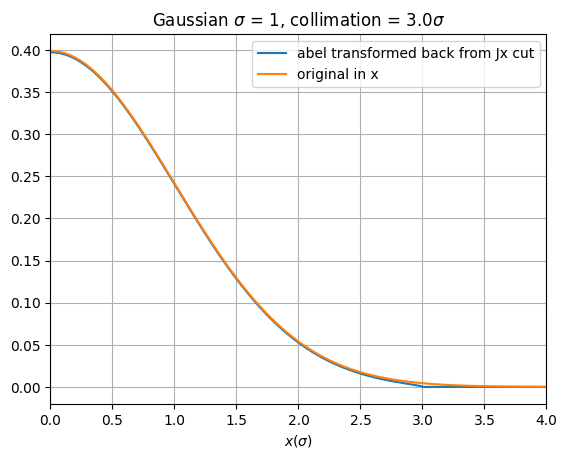

In [12]:
print(perc_g)

collim_x = np.sqrt(2*collim_position)
# integrate underneath the normal distribution
normalised_original = sp.integrate.trapz(gauss[10000:], x=r, dx=np.diff(r)[0], axis=-1,)


# integrate under the abel_qgauss, find the ratio, add the % then should work ... to see the full distribution as you expect from before... 

normalised_refound = sp.integrate.trapz(abel_forward_gauss, x=r, dx=1, axis=-1)
print(normalised_original, normalised_refound)


n_o = normalised_original
n_r = normalised_refound

normalisation_factor = (1-perc_g/100)*(n_o/n_r)
print(normalisation_factor)

plt.figure()
plt.plot(r, abel_forward_gauss*normalisation_factor,label='abel transformed back from Jx cut')
plt.plot(r, gauss[10000:], label='original in x')
plt.xlim([0,4])
plt.title('Gaussian $\sigma$ = 1, collimation = ' + str(collim_x) + '$\sigma$')
plt.grid()
plt.legend()
plt.xlabel('$x(\sigma)$')

### Example: For a q-Gaussian distribution 

Falling back to a pure Python backend...


Text(0, 0.5, 'p.d.f')

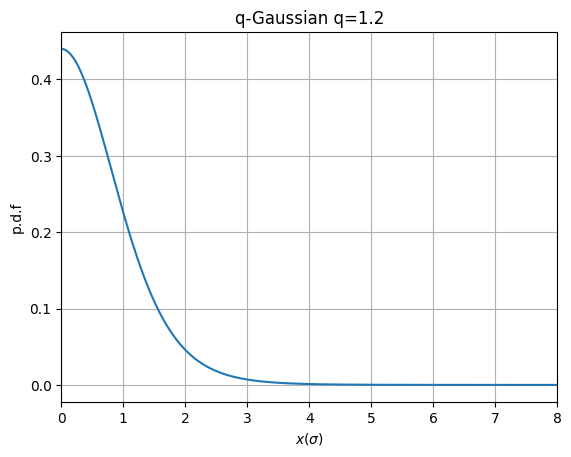

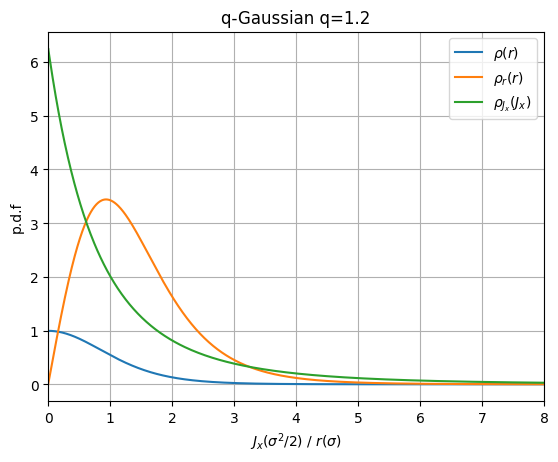

In [23]:
############ beam distribution symmetric about 0 
x = np.linspace(-100,100,20000)

q0=1.2
b0=1/(5-3*q0)


qgauss = xb.distributions.qGauss(x,mu=0,q=q0,A=1,b=b0)
qgauss = np.nan_to_num(qgauss.copy(), 0)

plt.plot(x,qgauss)
plt.xlim([0,8])
plt.grid()
plt.title('q-Gaussian q=' + str(q0))
plt.xlabel('$x(\sigma)$')
plt.ylabel('p.d.f')


############ Inverse Abel transform 

r = np.linspace(0.00001,100,10000)
abel_qgauss = direct_transform(qgauss[10000:], dr=np.diff(r)[0], direction="Inverse", correction=True)




rho_r_r_q = r*abel_qgauss*2*np.pi



########### Find the pdf in Jx 

pdf_jx_q = rho_r_r_q/r
jx = r**2/2


plt.figure()
plt.plot(r, abel_qgauss,label='$\\rho(r)$')
plt.legend()
plt.plot(r,rho_r_r_q, label='$\\rho_r(r)$')
plt.plot(jx,pdf_jx_q, label='$\\rho_{J_x}(J_x)$')
plt.legend()
plt.xlim([0,8])
plt.grid()
plt.title('q-Gaussian q=' + str(q0))
plt.xlabel('$J_x(\sigma^2/2$) / $r(\sigma)$')
plt.ylabel('p.d.f')





### Evaluate the lost particles with a collimator at $J_x =  sigma$

If we cute at 6 sigma, we integrate between 6 and infinite sigma to know the intensity in the beam in the Amplitude space 
for a Gaussian beam 





4.5 sigma cut takes  5.536275896380587 %


Text(0, 0.5, 'p.d.f')

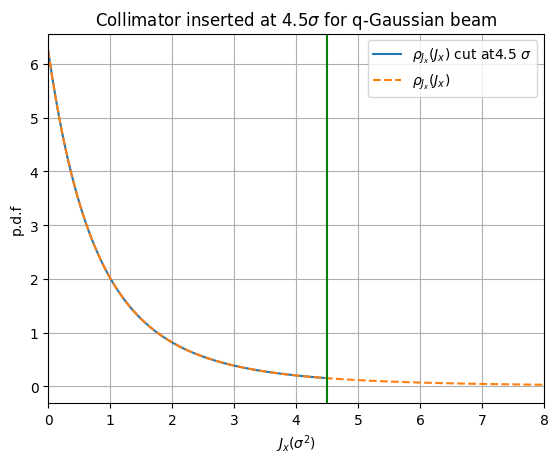

In [24]:
############ define your collimator position in J_x = x**2/2

collim_position = 3**2/2

############ Interpolate the pdf 

xcollim_q = np.linspace(0.0000,collim_position,1000) # 0 to 3 sigma
x = jx
y = pdf_jx_q
ycollim_q = np.interp(xcollim_q, x, y)


############# Integrate up to the collimator and then normalise

perc_cut = sp.integrate.simps(ycollim_q, x=xcollim_q, dx=1, axis=-1,)
perc_all = sp.integrate.simps(pdf_jx_q, x=jx, dx=1, axis=-1,)


############## calculate percentage lost 

perc_q = 100-(perc_cut/perc_all)*100
print(str(collim_position) , 'sigma cut takes ',  perc_q, '%')


############### plot
plt.figure()
plt.plot(xcollim_q, ycollim_q, label='$\\rho_{J_x}(J_x)$ cut at' + str(collim_position) +  ' $\sigma$ ')
plt.plot(jx,pdf_jx_q, linestyle= '--',label='$\\rho_{J_x}(J_x)$',)
plt.legend()
plt.grid()
plt.title('Collimator inserted at ' + str(collim_position) + '$\sigma$ for q-Gaussian beam')
plt.xlabel('$J_x(\\sigma^2)$')
plt.axvline(x=collim_position, color='g')
plt.xlim([0,8])
plt.ylabel('p.d.f')




### Now find the profile of the beam in $x(\sigma)$ after the cutting in $J_x$





Falling back to a pure Python backend...


(0.0, 6.0)

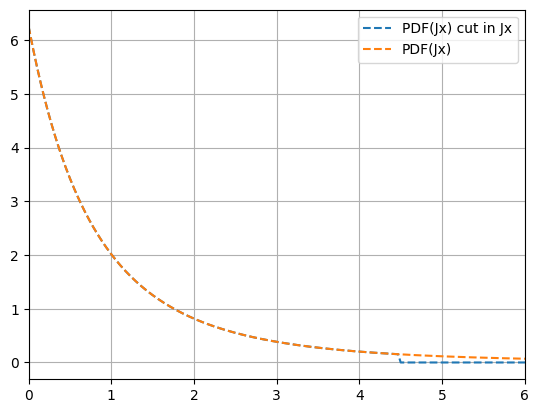

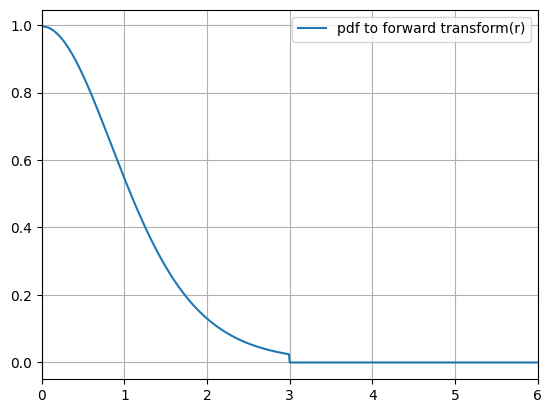

In [25]:
# find the index of Jx closest to collimation sigma



def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

nearest, idx = find_nearest(jx, collim_position)


# make the array 0 after collimation sigma to simulate the cutting in Jx from the collimator 

pdf_jx_cut = pdf_jx_q.copy()
pdf_jx_cut[idx:-1] = 0.0


# change the variables from J_x to r

pdf_r_cut = pdf_jx_cut*np.sqrt(2*jx)
r = np.sqrt(2*jx)


#Forward Abel transform 

pdf_to_forward = pdf_r_cut/(2*np.pi*r)
abel_forward_qgauss = direct_transform(pdf_to_forward.copy(), dr=np.diff(r)[0], direction="Forward", correction=True)


# Plot 



plt.figure()

plt.plot(jx, pdf_jx_cut, linestyle='--', label='PDF(Jx) cut in Jx')
plt.plot(jx, pdf_jx_q, linestyle='--', label='PDF(Jx)')
plt.xlim([0,6])
plt.grid()
plt.legend()

plt.figure()
plt.plot(r, pdf_r_cut/(2*np.pi*r), label='pdf to forward transform(r)')
plt.grid()
plt.legend()
plt.xlim([0,6])






5.536275896380587
0.49782482084531177 2.956589469784639
0.15905619298471882


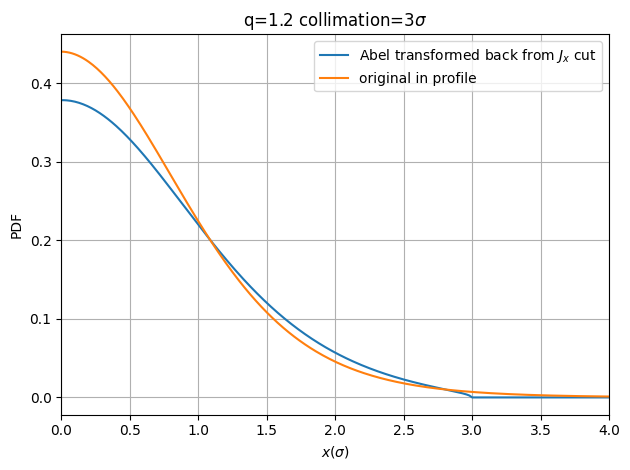

In [26]:
print(perc_q)
collim_x_q = 3

# integrate underneath the normal distribution
normalised_original = sp.integrate.trapz(qgauss[10000:], x=r, dx=0.1, axis=-1,)


# integrate under the abel_qgauss, find the ratio, add the % then should work ... to see the full distribution as you expect from before... 

normalised_refound = sp.integrate.trapz(abel_forward_qgauss, x=r, dx=0.1, axis=-1)
print(normalised_original, normalised_refound)


n_o = normalised_original
n_r = normalised_refound

normalisation_factor = (1-perc_q/100)*(n_o/n_r)
print(normalisation_factor)


plt.figure()
plt.plot(r, abel_forward_qgauss*normalisation_factor,label='Abel transformed back from $J_x$ cut')

plt.plot(r,qgauss[10000:], label='original in profile')
plt.xlim([0,4])
plt.title('q=' + str(q0) + ' collimation=' + str(collim_x_q) + '$\sigma$')
plt.grid()
plt.legend()
plt.xlabel('$x(\sigma)$')
plt.ylabel('PDF')
plt.tight_layout()

plt.savefig('./presentation_plots/q_' + str(q0) + '_profile.png', dpi=400 )


### Comparison for two different beam distributions

Gaussian, q-Gaussian:  1.1103200116124157 % 5.536275896380587 %


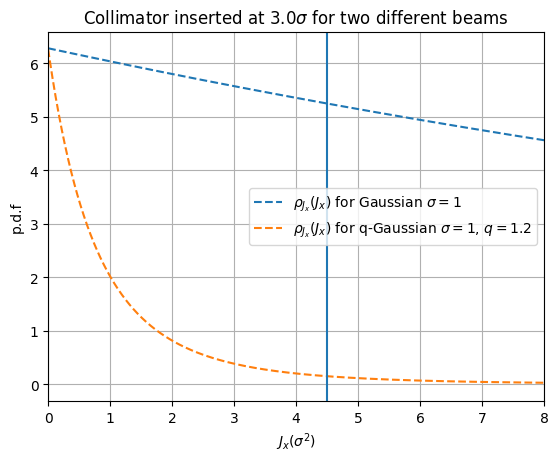

In [54]:
plt.plot(jx,pdf_jx_gauss, linestyle= '--',label='$\\rho_{J_x}(J_x)$ for Gaussian $\sigma=1$',)


plt.plot(jx,pdf_jx_q, linestyle= '--',label='$\\rho_{J_x}(J_x)$ for q-Gaussian $\sigma=1$, $q=$' + str(q0),)
plt.legend()
plt.grid()
plt.title('Collimator inserted at ' + str(collim_x) + '$\sigma$ for two different beams')
plt.xlabel('$J_x(\\sigma^2)$')
plt.axvline(x=collim_position)
plt.xlim([0,8])
plt.ylabel('p.d.f')

print('Gaussian, q-Gaussian: ', perc_g,'%', perc_q, '%')
